<h1>Example: Vlasov Equation</h1>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:

###
### General imports
###

#import time

import numpy              as np
import numpy.linalg       as la
import scipy.integrate    as spi
import matplotlib.pyplot  as plt

###
### Angle generation imports
###
from pyLIQTR.sim_methods.angler               import Angler
from pyLIQTR.sim_methods.expander             import Expander

###
### Operator simulation & Hamiltonian
### preperation imports
###
from pyLIQTR.sim_methods.simqsp             import SimQSP
import pyLIQTR.sim_methods.quantum_ops        as     qops    


###
### Imports to support the pyQSP Gate-Based simulation
###
import cirq

from pyLIQTR.QSP          import QSP       as   pQSP
from pyLIQTR.QSP.gen_qsp  import QSP_Simulator


###
### Ploting and text output settings
###

np.set_printoptions(precision=2)



We will provide an operator/matrix based simulation of how QSP can be used to solve the Vlasov-Hermite equation, and compare it against a purely classical simulation. For background on the Vlasov equation, consult tutorial 1a.

To begin, we will quickly simulate the model using purely classical methods (almost exactly as done in tutorial 1a).

<hr>
<h3>Generating the Vlasov-Hermite Hamiltonian and simulating it classically</h3>
We begin by defining the Hamiltonian for an $N = 3$ with no damping, since we do not currently support imaginary time evolutions.

In [2]:
N      =  3
k      =  2.0                                  # Fourier wavenumber

nu     =  0.0                                  # Collisional damping parameter : 
                                               # (for use only with statevector propagation)
                                               # (SET TO 0 for now, since imag otherwise)

alpha  =  0.6                                  # Electric field parameter

H = qops.hamiltonian_wfn_vlasov_hermite_linear_sym(k,alpha,nu,N)


Although our goal is to generate circuits for quantum simulation, it is helpful to have some classical reference values on hand as a sanity check.  To this end, we can use the Hamitonian matrix $H$, and set some initial parameters:

In [3]:
dt           =  0.1                           # Integration timestep Decrease this 
                                                 #   if you'd like a finer grain simulation
tmax         =  5                             # Maximal timestep
sclf         =  1                              # Scale factor for timestep sampling
Ns           =  int(np.ceil(tmax/dt))          # Total number of timesteps
timestep_vec = np.arange(0,tmax+dt,sclf*dt)    # Define array of timesteps

Next, we build up the initial wavefunction as a spin-up product state $\mid\psi_0\rangle = \bigotimes_{j=0}^{N-1} \mid \uparrow\rangle$ so that:

In [4]:
#Define the initial state. For this example only occupy the first qubit
occ_state = np.zeros(N)
occ_state[0] = 1

# Initialize the wavefunction
wfn = 0j

for j in range(N):
    if (occ_state[j] == 1):
        wfn += qops.state_multifermi_idx((j,),N)

wfn  = wfn / la.norm(wfn)
wfnp = qops.vectorize_cvec(wfn)

Finally, we simulate and plot the time evolution of our observable:

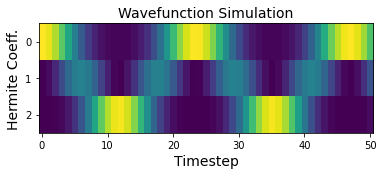

In [5]:
# hamiltonian for this simulation
HP            = qops.hamiltonian_wfn_vlasov_hermite_linear_sym(k,alpha,nu,N)

traj_raw_wfn  = spi.odeint(qops.prop_wfn,wfnp,timestep_vec,args=(HP,))
traj_proc_wfn = qops.parse_wfn_trajz_pzpj(timestep_vec,traj_raw_wfn)


# Visualize the projection over time:
#plt.figure(figsize=(5,5), dpi=300)
plt.imshow(np.transpose(traj_proc_wfn[:,1:(N+1)].real),cmap='viridis', interpolation='nearest',
                        aspect=Ns/(3*N))
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Hermite Coeff.',fontsize=14)
plt.title('Wavefunction Simulation',fontsize=14)
plt.show()


<h3>QSP: Operator-Level Simulation</h3>

Having generated some reference data, we can use an operator-level simulations of QSP to verify the accuracy of a given phase angle sequence.  We do, however,  encounter an additional consideration: the Hamiltonian must satisfy the condition $\vert\vert H \vert\vert_2 \leq 1$ for us to represent it within a block encoding.  This is not true for the Vlasov-Hermite Hamiltonian that we generated above:

In [6]:

evals,evecs = la.eig(H)

print("Max Eigenvalue: ", np.max(evals))
print("Min Eigenvalue: ", np.min(evals))


Max Eigenvalue:  (2.683281572999749+0j)
Min Eigenvalue:  (-2.6832815729997503+0j)


We can correct this to satisfy the norm condition by using a minmax rescaling.  To get the same physical dynamics, we must adjust the target timepoints accordingly:

In [7]:

e_min = np.min(evals)
e_max = np.max(evals)

ID_n = np.eye(2**N)

H_rs = (H - e_min*ID_n) / (e_max - e_min)        # min/max rescaling

timestep_vec_rescaled  = timestep_vec*(e_max-e_min)  



The next step is to generate phase angles that encode the exponential time evolution operator with QSP.  We begin by calculating a polynomial expansion for the sine and cosine terms that are used to represent the time evolution operator $\exp[-\imath H t] = \cos (Ht) -\imath \sin (Ht)$.  Fortunately, there is a well-controlled Jacobi-Anger expansion for these trigonometric functions, which we may produce using the the `Exander` module of `pyLIQTR`.  The resulting Chebyshev polynomials can then be passed to the `Angler` model for optimizer-based phase angle generation.  

For brevity, we subsample the timesteps used for the exact simulation:


In [8]:

N_tpts   =  8

npts     =  1000;      xpts = np.linspace(-1.0,1.0,npts)
eps0     =  1e-6

 
p_cos    =  Expander()
p_sin    =  Expander()

ang_cos  =  []
ang_sin  =  []

timestep_vec_subsample = timestep_vec_rescaled               # Select a subset of points
                                                             # from the rescaled timesteps.

for tau in timestep_vec_subsample:

    p_cos.ja_cos(tau,eps0)         # Generate Jacobi-Anger (JA) expansions for
    p_sin.ja_sin(tau,eps0)         # the sine and cosine at timestep tau.
    
    ang_cos.append(Angler( cheb_poly=p_cos, bfgs_conv=1e-14, max_iter=400 ))   # Create phase optimizers
    ang_sin.append(Angler( cheb_poly=p_sin, bfgs_conv=1e-14, max_iter=400 ))   # for the JA expansions

    ang_cos[-1].gradient_optimization();     # Run the optimizations
    ang_sin[-1].gradient_optimization();



################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			2.116542e-04
2 			8.906092e-06
3 			3.418495e-09
4 			5.985460e-14
5 			4.091089e-22
6 			9.860761e-32

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			2.024634e-32

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
####################

/Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/sim_methods/expander.py:223: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs[j-1] = ((-1)**(j-1))*sfn.jv(2*(j-1),tau)
/Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/sim_methods/expander.py:277: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs[j-1] = ((-1)**(j-1)) * sfn.jv(2*j - 1,tau)
/Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/sim_methods/angler.py:618: RuntimeWarning: divide by zero encountered in scalar divide
  mem_dot[mem_now]    = 1.0/(mem_grad[mem_now,:] @ mem_obj[mem_now,:])


14 			1.139534e-29

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			3.819076e-06
2 			1.844536e-08
3 			2.922584e-12
4 			4.040153e-15
5 			1.114605e-18
6 			1.307266e-21
7 			3.648336e-25
8 			4.393524e-28
9 			2.603857e-31

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			2.085117e-04
2 			1.263689e-05
3 			5.755841e-08
4 			7.737891e-10
5 			8.288694e-12
6 			9.606181e-14
7 			8.346252e-16
8

3 			5.913317e-08
4 			1.005358e-09
5 			8.112723e-12
6 			3.430208e-13
7 			5.321911e-15
8 			8.633876e-17
9 			9.377973e-19
10 			5.034884e-21
11 			4.187255e-23
12 			1.710988e-25
13 			4.510560e-27
14 			2.037634e-29

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			3.878307e-04
2 			2.738782e-05
3 			1.723805e-07
4 			2.932185e-09
5 			2.538542e-10
6 			5.940061e-12
7 			4.874498e-14
8 			6.225861e-16
9 			4.950298e-18
10 			5.668277e-20
11 			5.444356e-22
12 			5.383712e-24
13 			8.604397e-26
14 			8.154484e-28
15 			9.373886e-30

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
###############################################################################

9 			1.178037e-17
10 			1.284265e-19
11 			3.764626e-21
12 			8.167058e-23
13 			1.181515e-24
14 			1.691116e-26
15 			1.558062e-28
16 			3.851860e-30

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			2.560693e-04
2 			1.979512e-05
3 			1.286115e-07
4 			1.459306e-09
5 			1.261954e-11
6 			4.702275e-13
7 			4.812992e-15
8 			8.228819e-17
9 			6.662747e-19
10 			3.796982e-21
11 			9.555529e-23
12 			2.974480e-24
13 			5.056944e-26
14 			1.069105e-27
15 			3.260214e-30

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination  

4 			4.105821e-09
5 			3.441791e-11
6 			7.121452e-13
7 			1.437477e-14
8 			1.140183e-16
9 			1.261395e-18
10 			3.095822e-20
11 			1.170920e-21
12 			2.514701e-23
13 			1.960070e-25
14 			4.150163e-28
15 			4.492809e-30

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			4.815556e-04
2 			3.631663e-05
3 			3.584313e-07
4 			8.700733e-09
5 			1.568847e-10
6 			3.744271e-12
7 			3.358678e-14
8 			5.512008e-16
9 			1.229073e-17
10 			3.390926e-19
11 			6.519303e-21
12 			9.398707e-23
13 			5.947948e-25
14 			1.416410e-26
15 			8.948795e-29

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
##############################################################################

6 			3.581827e-12
7 			4.012726e-14
8 			4.691521e-16
9 			1.238727e-17
10 			3.185883e-19
11 			6.195423e-21
12 			5.937418e-23
13 			5.711792e-25
14 			2.072951e-26
15 			5.789638e-28
16 			5.922620e-30

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			4.280692e-04
2 			2.380497e-05
3 			3.027485e-07
4 			7.946954e-09
5 			1.219308e-10
6 			4.319924e-12
7 			6.069520e-14
8 			5.924626e-16
9 			1.247172e-17
10 			6.188525e-19
11 			3.789130e-21
12 			4.080804e-23
13 			1.038101e-24
14 			2.844862e-26
15 			6.154101e-28
16 			1.061419e-29

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
############################################################################

6 			1.951317e-12
7 			3.964229e-14
8 			1.252977e-15
9 			1.216768e-17
10 			5.607691e-19
11 			1.035558e-20
12 			8.125536e-23
13 			1.608239e-24
14 			1.802116e-26
15 			5.041068e-28
16 			2.002351e-29

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			4.729356e-04
2 			2.830411e-05
3 			4.345004e-07
4 			1.267289e-08
5 			1.517475e-10
6 			7.353992e-12
7 			1.055517e-13
8 			1.245682e-15
9 			2.564594e-17
10 			1.220331e-18
11 			9.453714e-21
12 			5.907331e-23
13 			1.597803e-24
14 			4.557940e-26
15 			7.020015e-28
16 			1.061419e-29

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
############################################################################

6 			1.976136e-12
7 			2.995955e-14
8 			9.998552e-16
9 			1.008208e-17
10 			4.938754e-19
11 			8.715059e-21
12 			9.512986e-23
13 			1.496651e-24
14 			2.361533e-26
15 			4.214382e-28
16 			1.061419e-29

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			4.704806e-04
2 			3.368553e-05
3 			5.285342e-07
4 			1.587118e-08
5 			2.603966e-10
6 			7.900807e-12
7 			1.280499e-13
8 			2.097976e-15
9 			2.950465e-17
10 			1.876345e-18
11 			3.068013e-20
12 			1.102622e-22
13 			2.270027e-24
14 			1.067566e-25
15 			7.636174e-28
16 			8.899337e-30

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
############################################################################

5 			9.709741e-11
6 			1.910478e-12
7 			3.546614e-14
8 			5.330732e-16
9 			1.292768e-17
10 			4.504091e-19
11 			8.329666e-21
12 			9.945822e-23
13 			1.095503e-24
14 			2.828995e-26
15 			7.571231e-28
16 			9.615783e-30

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
################################################################################
#             GRADIENT OPTIMIZER for QSP Phase Angle Determination             #
################################################################################ 


Iteration		Max. Obj.

1 			5.061736e-04
2 			3.809461e-05
3 			6.480161e-07
4 			1.954732e-08
5 			2.783680e-10
6 			1.662761e-11
7 			2.145403e-13
8 			2.746566e-15
9 			7.001165e-17
10 			2.202513e-18
11 			1.764305e-20
12 			2.402607e-22
13 			5.766427e-24
14 			1.647614e-25
15 			3.480554e-27
16 			1.967376e-29

GRADOPT-LBFGS: Optimization converged to target accuracy (max_obj < 1e-28 ).
##########################################################

Operator-level simulations are performed using the `SimQSP` class.  The QSP phase angles are passed when constructing the object, and the standard (minimal) block encoding is prepared by calling the member function `get_qsp_operators`:

In [9]:

# Note that this isn't very efficient since we could just evaluate 
# the sequences directly as opposed to saving stuff.

qsp_sims_cos = []
qsp_sims_sin = []

for j in range(len(ang_cos)):
    
    qsp_sims_cos.append(SimQSP(angler=ang_cos[j]))        # Create a simulation object
    qsp_sims_sin.append(SimQSP(angler=ang_sin[j]))        # for each angle set (and thus timepoint)
    
    qsp_sims_cos[-1].get_qsp_operators(H_rs)              # Build a block encoding for the
    qsp_sims_sin[-1].get_qsp_operators(H_rs)              # simulation object


We set the signal state for our $R$-convention QSP encoding:

In [10]:

sig_qsp  = np.kron(np.array([[1,1]]),np.eye(2**N)) / np.sqrt(2)


And can generate the time evolution operator $U(t_n) = \exp(-\imath H t_n)$ for each timepoint $t_n$ of interest:

In [11]:

unitary_cos = []
unitary_sin = []
unitary_exp = []


for j in range(len(qsp_sims_cos)):

    ## The factor of 2 below comes from the fact that we have encoded sin/2 and cos/2
    ## 
    unitary_cos.append( 2 * sig_qsp @ qsp_sims_cos[j].qsp_sequence() @ sig_qsp.T )
    unitary_sin.append( 2 * sig_qsp @ qsp_sims_sin[j].qsp_sequence() @ sig_qsp.T )

    unitary_exp.append( unitary_cos[-1] - 1j*unitary_sin[-1] )
   

This operator can be used to generate the wavefunction at each timepoint (e.g., $|\psi(t_n)\rangle = \exp(-\imath H t_n)\, |\psi(0)\rangle$):

In [12]:

traj_wfn_qsp_op = []

for j in range(len(unitary_exp)):
    
    traj_wfn_qsp_op.append( unitary_exp[j] @ wfn.T )


This gives a set of statevectors, which can be used to calculate  the $Z$ spin projection for each lattice site and timepoint:

In [13]:

nwfn = len(traj_wfn_qsp_op)

obs_operator = np.zeros((nwfn,N))

for j in range(nwfn):
    obs_operator[j,:] = qops.measure_obs_site(traj_wfn_qsp_op[j],qops.przp)
    

While more coarsely-grained in time, we see similar behavior to the classical computations:

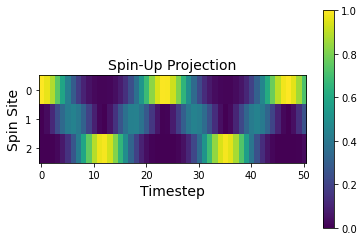

In [14]:

N_ticks = 8


plt.imshow(np.transpose(obs_operator.real),
           cmap='viridis', interpolation='nearest',aspect=Ns/(3*N))
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)

plt.colorbar()

plt.show()


In fact, we can make a direct comparison with the exact result.  After doing so, we see robust agreement:

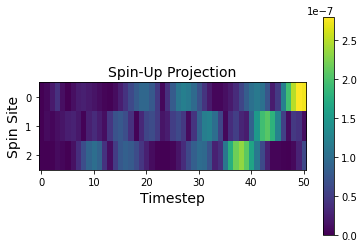

5.720446496106314e-08


In [15]:
traj_diff = np.abs(obs_operator.real - traj_proc_wfn[:,1:(N+1)].real)

N_ticks = 8

plt.imshow(np.transpose(traj_diff),
           cmap='viridis', interpolation='nearest',aspect=Ns/(3*N))
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)

plt.colorbar()
plt.show()

print(np.mean(traj_diff))
